In [1]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt

import sys
from pathlib import Path

repo_parent = Path.cwd().resolve().parents[0]
if str(repo_parent) not in sys.path:
    sys.path.insert(0, str(repo_parent))

# 3) Autoreload to pick up edits to Maurice2/*
%load_ext autoreload
%autoreload 2

from main.dynamics import Dynamics

In [2]:
xhat0 = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]) # Initial state estimate
sampling_rate = 50.0  # Hz
dt = 1.0 / sampling_rate

dynamics = Dynamics(dt=dt, x0=xhat0)
dynamics.setup_eom()
dynamics.run_rk4(xhat=xhat0)

t: 0.020
t: 0.040
t: 0.060
t: 0.080
t: 0.100
t: 0.120
t: 0.140
t: 0.160
t: 0.180
t: 0.200
t: 0.220
t: 0.240
t: 0.260
t: 0.280
t: 0.300
t: 0.320
t: 0.340
t: 0.360
t: 0.380
t: 0.400
t: 0.420
t: 0.440
t: 0.460
t: 0.480
t: 0.500
t: 0.520
t: 0.540
t: 0.560
t: 0.580
t: 0.600
t: 0.620
t: 0.640
t: 0.660
t: 0.680
t: 0.700
t: 0.720
t: 0.740
t: 0.760
t: 0.780
t: 0.800
t: 0.820
t: 0.840
t: 0.860
t: 0.880
t: 0.900
t: 0.920
t: 0.940
t: 0.960
t: 0.980
t: 1.000
t: 1.020
t: 1.040
t: 1.060
t: 1.080
t: 1.100
t: 1.120
t: 1.140
t: 1.160
t: 1.180
t: 1.200
t: 1.220
t: 1.240
t: 1.260
t: 1.280
t: 1.300
t: 1.320
t: 1.340
t: 1.360
t: 1.380
t: 1.400
t: 1.420
t: 1.440
t: 1.460
t: 1.480
t: 1.500
t: 1.520
t: 1.540
t: 1.560
t: 1.580
t: 1.600
t: 1.620
t: 1.640
t: 1.660
t: 1.680
t: 1.700
t: 1.720
t: 1.740
t: 1.760
t: 1.780
t: 1.800
t: 1.820
t: 1.840
t: 1.860
t: 1.880
t: 1.900
t: 1.920
t: 1.940
t: 1.960
t: 1.980
t: 2.000
t: 2.020
t: 2.040
t: 2.060
t: 2.080
t: 2.100
t: 2.120
t: 2.140
t: 2.160
t: 2.180
t: 2.200
t: 2.220
t

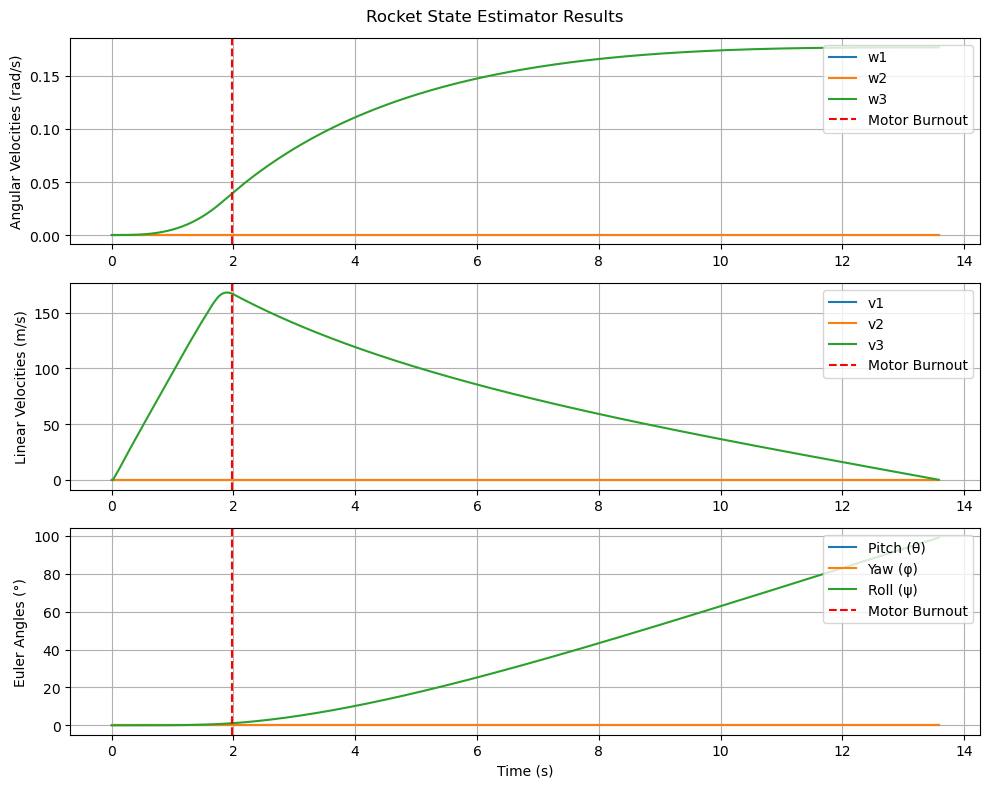

In [3]:
xhat = np.array(dynamics.states)
t = np.arange(0, xhat.shape[0]*dynamics.dt, dynamics.dt)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=False)
fig.suptitle('Rocket State Estimator Results')
axs[0].plot(t, xhat[:, 0], label='w1')
axs[0].plot(t, xhat[:, 1], label='w2')
axs[0].plot(t, xhat[:, 2], label='w3')
axs[0].axvline(dynamics.t_motor_burnout, color='r', linestyle='--', label='Motor Burnout')
axs[0].set_ylabel('Angular Velocities (rad/s)')
axs[0].legend(loc='upper right')
axs[0].grid()
axs[1].plot(t, xhat[:, 3], label='v1')
axs[1].plot(t, xhat[:, 4], label='v2')
axs[1].plot(t, xhat[:, 5], label='v3')
axs[1].axvline(dynamics.t_motor_burnout, color='r', linestyle='--', label='Motor Burnout')
axs[1].set_ylabel('Linear Velocities (m/s)')
axs[1].legend(loc='upper right')
axs[1].grid()

# Convert quaternion to Euler angles for plotting
euler_angles = np.array([dynamics.quat_to_euler_xyz(q) for q in xhat[:, 6:10]])
axs[2].plot(t, np.rad2deg(euler_angles[:, 0]), label='Pitch (θ)')
axs[2].plot(t, np.rad2deg(euler_angles[:, 1]), label='Yaw (φ)')
axs[2].plot(t, np.rad2deg(euler_angles[:, 2]), label='Roll (ψ)')
axs[2].axvline(dynamics.t_motor_burnout, color='r', linestyle='--', label='Motor Burnout')
axs[2].set_ylabel('Euler Angles (°)')
axs[2].set_xlabel('Time (s)')
axs[2].legend(loc='upper right')
axs[2].grid()
plt.tight_layout()

In [5]:
dynamics.f_params

Matrix([
[-3.48432055749129*w_1*(0.00019632061771875*pi*(-1.218276*Piecewise((0, atan(sqrt(v_1**2 + v_2**2 + 1.0e-6)/(v_3 + 0.001)) <= 0.001), (Min(pi/12, atan(sqrt(v_1**2 + v_2**2 + 1.0e-6)/(v_3 + 0.001))), True))/pi + 0.214851)**2*sqrt(v_1**2 + v_2**2 + v_3**2 + 1.0e-6)*Piecewise((0, atan(sqrt(v_1**2 + v_2**2 + 1.0e-6)/(v_3 + 0.001)) <= 0.001), (Min(pi/12, atan(sqrt(v_1**2 + v_2**2 + 1.0e-6)/(v_3 + 0.001))), True)) + 0.0515524479959411) + 0.98780487804878*w_2*w_3 + 0.000684043964176829*pi*(-1.218276*Piecewise((0, atan(sqrt(v_1**2 + v_2**2 + 1.0e-6)/(v_3 + 0.001)) <= 0.001), (Min(pi/12, atan(sqrt(v_1**2 + v_2**2 + 1.0e-6)/(v_3 + 0.001))), True))/pi + 0.214851)*(v_1**2 + v_2**2 + v_3**2 + 1.0e-6)*Piecewise((0, atan(sqrt(v_1**2 + v_2**2 + 1.0e-6)/(v_3 + 0.001)) <= 0.001), (Min(pi/12, atan(sqrt(v_1**2 + v_2**2 + 1.0e-6)/(v_3 + 0.001))), True))*sin(2*atan2(v_2, v_1 + sqrt(v_1**2 + v_2**2 + 1.0e-6)))],
[-0.98780487804878*w_1*w_3 - 3.48432055749129*w_2*(0.00019632061771875*pi*(-1.218276*Pie